Carlos Garcia - 21000475

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

### Datos

In [2]:
data = pd.read_excel('./input/estaturas.xlsx', sheet_name = 'normales', names = ['Estatura', 'Edad']) 
data.head()

,Estatura,Edad
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


In [3]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data.values)
data[0:10, :]

array([[0.62857143, 0.15625   ],
       [0.54285714, 0.3125    ],
       [0.48571429, 0.09375   ],
       [0.65714286, 0.40625   ],
       [0.28571429, 0.34375   ],
       [0.31428571, 0.25      ],
       [0.25714286, 0.1875    ],
       [0.85714286, 0.40625   ],
       [0.85714286, 0.15625   ],
       [0.57142857, 0.        ]])

### Modelos

In [4]:
def kmeans(x, k = 1, iterate = 10, kprint = True):
    #Initialize variables
    clusters = np.full((x.shape[0], 1), k)
    distance = np.zeros((x.shape[0], k))
    changes = 1
    count = 0

    #Randomly select centroids
    centroid_index = np.random.choice(len(x), size = (k), replace = False)
    centroids = x[centroid_index, :]
    
    #Iterative cluster algorithm
    while changes > 0 and count < iterate:

        #Calculate euclidean distance
        for i in range(0, k):       
            d = np.sqrt(np.sum(np.power(x - centroids[i, :], 2), axis = 1))
            distance[:, i] = d.T

        #Cluster assignment
        #print(np.sum(np.isin(distance, [0]), axis = 1))
        assignment = np.expand_dims(np.argmin(distance, axis = 1), 1)
        changes = np.sum(np.not_equal(clusters, assignment))
        clusters = assignment
        count += 1

        #Update centroids
        within_distance = 0
        for i in range(0, k):
            k_condition = np.where(clusters == i)[0]
            centroids[i, :] = np.mean(x[k_condition, :], axis = 0)
            within_distance += np.sum(np.power(x[k_condition, :] - centroids[i, :], 2))

        if kprint:
            print('Total cluster within distance = {}'.format(within_distance))

    result = {'clusters': clusters, 'centroids': centroids, 'within': within_distance}
    return result

In [5]:
def getGMM(x, k = 1):
    gm = GaussianMixture(n_components = k).fit(x)
    clusters = np.expand_dims(gm.predict(data), 1)

    centroids = np.zeros((k, x.shape[1]))
    within_distance = 0
    for i in range(0, k):
        k_condition = np.where(clusters == i)[0]
        centroids[i, :] = np.mean(x[k_condition, :], axis = 0)
        within_distance += np.sum(np.power(x[k_condition, :] - centroids[i, :], 2))

    result = {'model': gm, 'clusters': clusters, 'centroids': centroids, 'within': within_distance}
    return result

In [6]:
def plotClusters(x, clusters, centroids):
    plt.scatter(x = x[:, 0], y = x[:, 1], c = clusters[:, 0])
    plt.plot(centroids[:, 0], centroids[:, 1], 'kx', markersize = 15)
    plt.show()

In [7]:
def elbowGraph(x, max_k = 10, method = 'kmeans'):
    withinss = []
    for k in range(2, max_k):
        if method == 'kmeans':
            result = kmeans(x, k, kprint = False)
        else: 
            result = getGMM(data, k)
        
        withinss.append(result['within'])

    plt.plot(np.arange(2, max_k), withinss, 'o-', color = 'blue')
    plt.title('Elbow method')
    plt.xlabel('# clusters')
    plt.ylabel('Within SS')
    plt.show()

### Experimentos

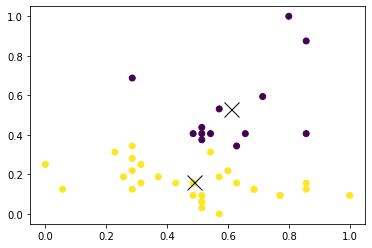

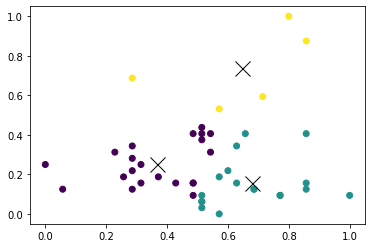

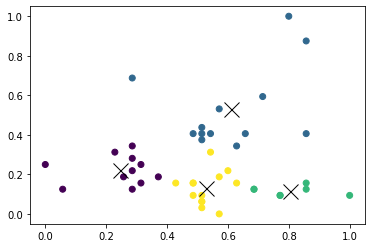

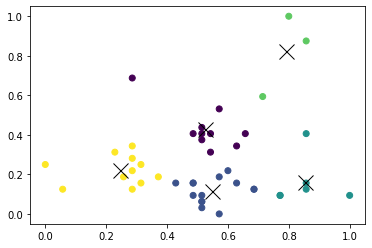

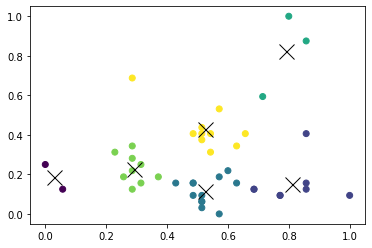

In [8]:
for i in range(2, 7):
    kmean_data = kmeans(data, i, kprint = False)
    plotClusters(data, kmean_data['clusters'], kmean_data['centroids'])

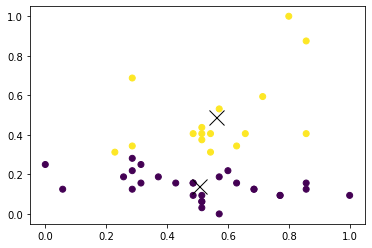

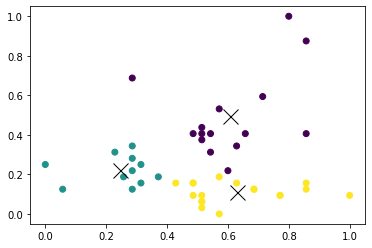

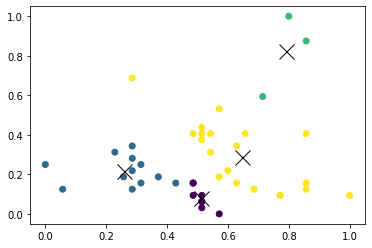

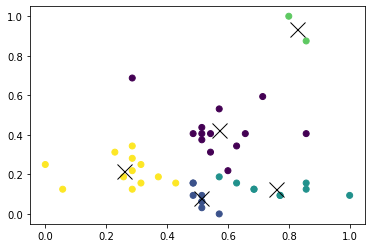

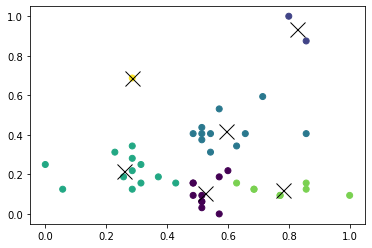

In [9]:
for i in range(2, 7):
    gm = getGMM(data, i)
    plotClusters(data, gm['clusters'], gm['centroids'])

Luego de experimentar con diferente valores de **K**, una inspección gráfica de los modelos generados por los modelo de k-means y GMM presentan una asignación única a cada observación, por lo cual si es posible aplicar hard-clustering para estos datos.

### Método del codo y selección de K

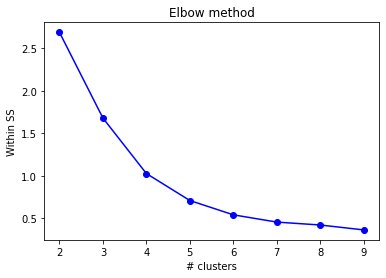

In [13]:
elbowGraph(data, 10, method = 'kmeans')

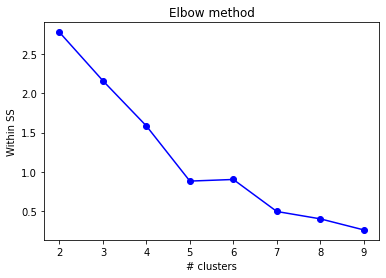

In [15]:
elbowGraph(data, 10, method = 'gmm')

Dado que en este escenario no se conoce de antemano la cantidad de grupos (clusters) a generar, el método del codo es de utilidad para determinar el número de clusters que minimiza la distancia intra-clusters, mejorando así la cohesión de los datos. 
De esta forma se selecciona un valor de k = 5, ya que las gráficas generadas para ambos modelos muestran un codo o bien comienzan a converger alrededor de este valor.

In [16]:
kmean_data = kmeans(data, 5, kprint = False)
gm = getGMM(data, 5)

### Evaluación

In [17]:
test = pd.read_excel('./input/estaturas.xlsx', sheet_name = 'valtest(normales)', names = ['Estatura', 'Edad'])
test.head()

,Estatura,Edad
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30


In [18]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test.values)
test

array([[1.        , 0.        ],
       [0.90909091, 0.2       ],
       [0.        , 0.6       ],
       [0.        , 1.        ],
       [1.        , 0.5       ],
       [0.72727273, 0.7       ],
       [0.86363636, 0.6       ],
       [0.04545455, 0.6       ]])

In [19]:
def kmeans_predict(x, centroids):
    #Initialize variables
    k = centroids.shape[0]
    distance = np.zeros((x.shape[0], k))

    #Calculate euclidean distance
    for i in range(0, k):       
        d = np.sqrt(np.sum(np.power(x - centroids[i, :], 2), axis = 1))
        distance[:, i] = d.T

    #Cluster assignment
    assignment = np.expand_dims(np.argmin(distance, axis = 1), 1)

    return assignment    

In [20]:
test_kmeans = kmeans_predict(test, kmean_data['centroids'])
test_kmeans

array([[0],
       [0],
       [3],
       [3],
       [1],
       [1],
       [1],
       [3]], dtype=int64)

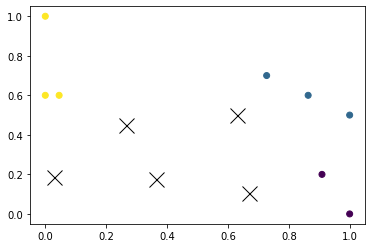

In [21]:
plotClusters(test, test_kmeans, kmean_data['centroids'])

In [22]:
probs = gm['model'].predict_proba(test)
probs

array([[1.20503436e-203, 0.00000000e+000, 3.57332334e-001,
        1.60683339e-005, 6.42651598e-001],
       [7.32208924e-206, 0.00000000e+000, 9.42166889e-001,
        9.70227648e-004, 5.68628834e-002],
       [2.71143619e-096, 0.00000000e+000, 9.99692671e-001,
        3.07328811e-004, 4.23941838e-054],
       [2.76765966e-076, 0.00000000e+000, 1.00000000e+000,
        1.88424000e-022, 2.69642191e-220],
       [0.00000000e+000, 3.58051028e-153, 9.99999950e-001,
        5.02304479e-008, 5.82368270e-058],
       [4.39001705e-281, 0.00000000e+000, 1.00000000e+000,
        4.83586905e-012, 3.58962481e-117],
       [0.00000000e+000, 0.00000000e+000, 9.99999999e-001,
        1.17431778e-009, 3.66525422e-085],
       [1.10487961e-073, 0.00000000e+000, 9.99850270e-001,
        1.49730125e-004, 1.29676587e-055]])

### Simulación

In [23]:
def estatura_edad(X):
  return X[:,0] / X[:,1]

In [24]:
muestra, cluster = gm['model'].sample(1000)

muestra_g = estatura_edad(muestra)  
valor_esperado = np.mean(muestra_g)

In [25]:
print("El valor esperado de estatura_edad(X) es:{}".format(valor_esperado))

El valor esperado de estatura_edad(X) es:3.6041639591366135
